## 1. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from spotoptim import SpotOptim
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from scipy.stats import norm

np.random.seed(42)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
print("✓ Setup complete!")

✓ Setup complete!


In [2]:
# Benchmark functions
def branin(X):
    X = np.atleast_2d(X)
    x1, x2 = X[:, 0], X[:, 1]
    return (x2 - 5.1/(4*np.pi**2)*x1**2 + 5/np.pi*x1 - 6)**2 + 10*(1-1/(8*np.pi))*np.cos(x1) + 10

def sphere(X):
    X = np.atleast_2d(X)
    return np.sum(X**2, axis=1)

print("✓ Benchmark functions loaded")

✓ Benchmark functions loaded


## 2. Convergence Plots

Track optimization progress over iterations.

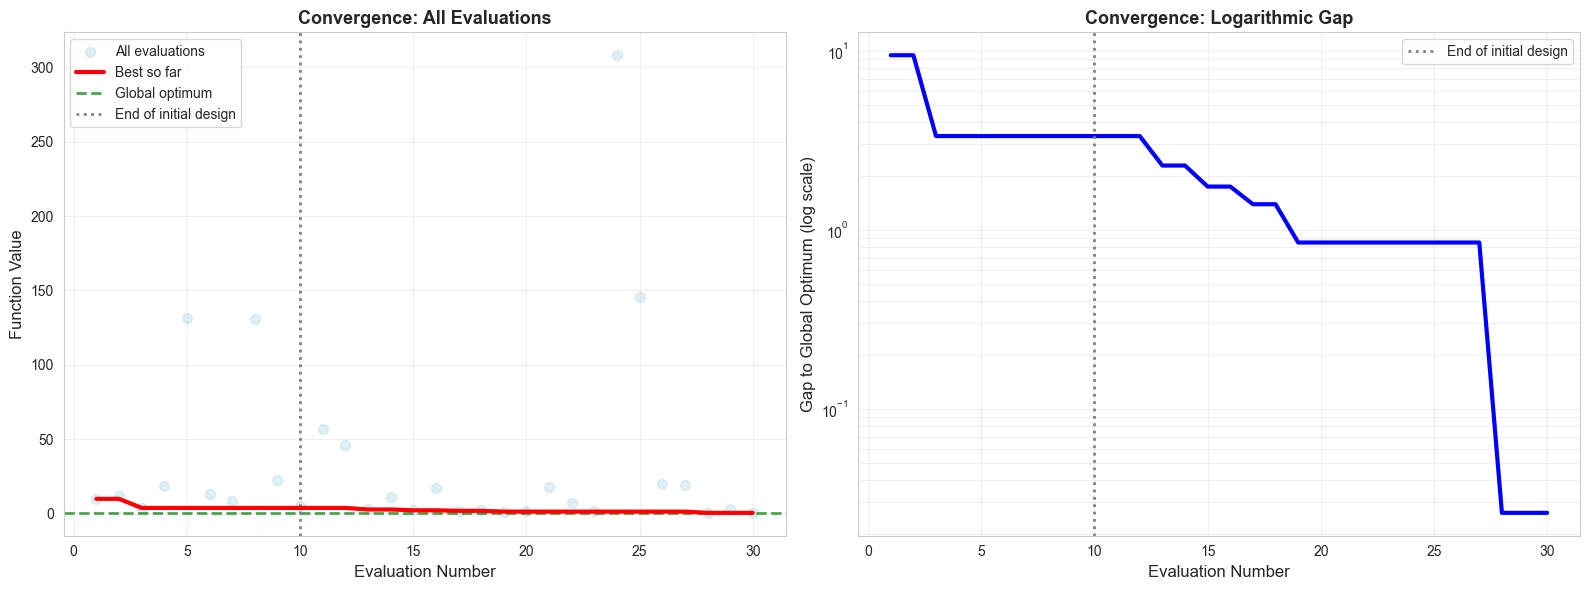


📊 Convergence Statistics:
  Initial best:  3.737228
  Final best:    0.424132
  Global opt:    0.397887
  Improvement:   3.313096
  Sequential iterations: 20


In [3]:
# Run optimization
opt = SpotOptim(
    fun=branin,
    bounds=[(-5, 10), (0, 15)],
    n_initial=10,
    max_iter=30,
    seed=42
)

result = opt.optimize()

# Extract history
evaluations = np.arange(1, len(opt.y_) + 1)
all_values = opt.y_
best_so_far = np.minimum.accumulate(all_values)

# Plot convergence
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: All evaluations vs best so far
ax1.scatter(evaluations, all_values, alpha=0.4, s=50, label='All evaluations', color='lightblue')
ax1.plot(evaluations, best_so_far, 'r-', linewidth=3, label='Best so far', zorder=5)
ax1.axhline(0.397887, color='green', linestyle='--', linewidth=2, label='Global optimum', alpha=0.7)
ax1.axvline(opt.n_initial, color='gray', linestyle=':', linewidth=2, label='End of initial design')
ax1.set_xlabel('Evaluation Number', fontsize=12)
ax1.set_ylabel('Function Value', fontsize=12)
ax1.set_title('Convergence: All Evaluations', fontweight='bold', fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right: Log scale for fine details
gap_to_optimum = best_so_far - 0.397887
ax2.semilogy(evaluations, gap_to_optimum, 'b-', linewidth=3)
ax2.axvline(opt.n_initial, color='gray', linestyle=':', linewidth=2, label='End of initial design')
ax2.set_xlabel('Evaluation Number', fontsize=12)
ax2.set_ylabel('Gap to Global Optimum (log scale)', fontsize=12)
ax2.set_title('Convergence: Logarithmic Gap', fontweight='bold', fontsize=13)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print(f"\n📊 Convergence Statistics:")
print(f"  Initial best:  {all_values[:opt.n_initial].min():.6f}")
print(f"  Final best:    {best_so_far[-1]:.6f}")
print(f"  Global opt:    {0.397887:.6f}")
print(f"  Improvement:   {all_values[:opt.n_initial].min() - best_so_far[-1]:.6f}")
print(f"  Sequential iterations: {len(all_values) - opt.n_initial}")

## 3. Response Surface Visualization (2D)

Visualize the true function, surrogate, and sampled points.

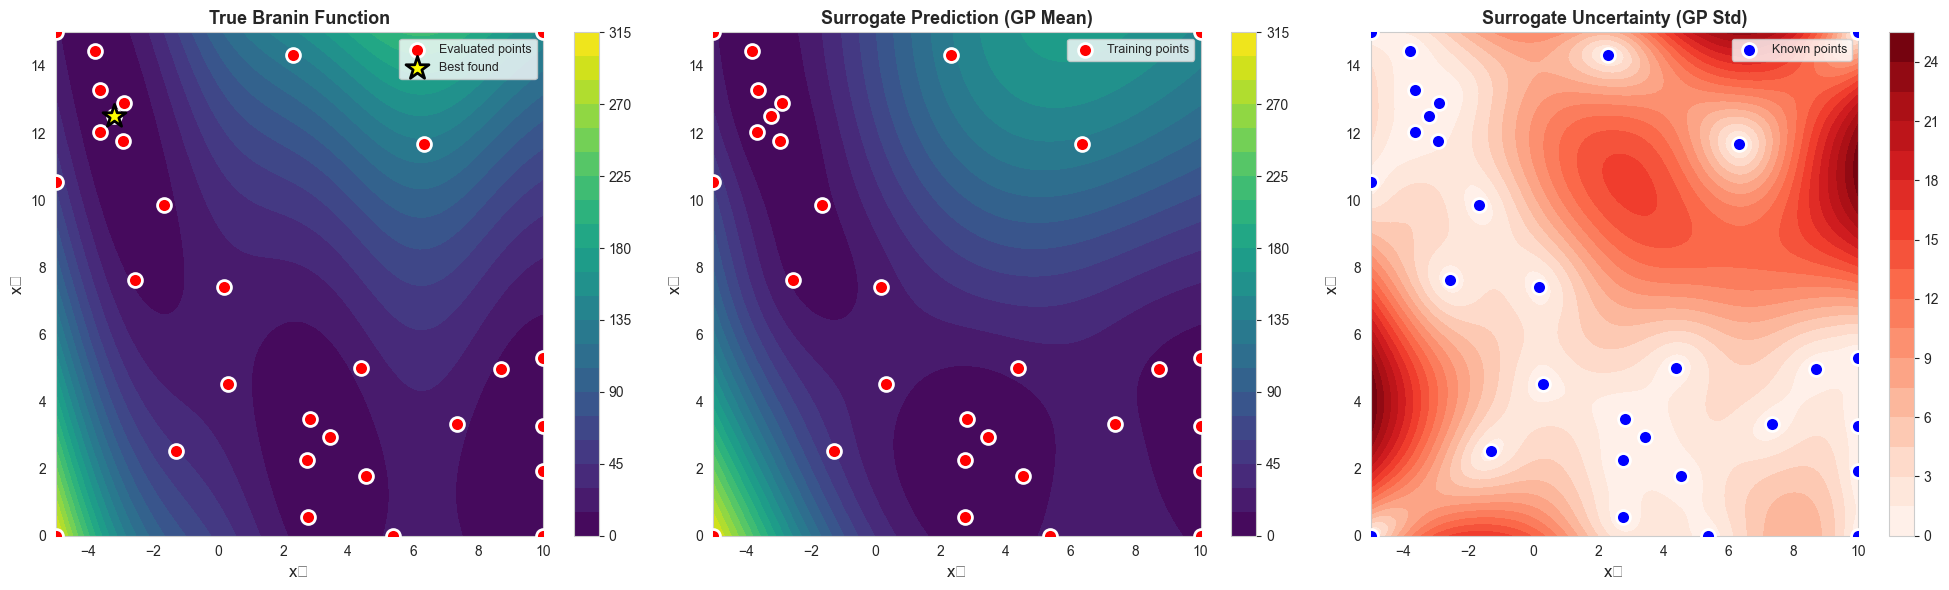


💡 Key Observations:
  - Surrogate closely matches true function where data exists
  - Uncertainty is low near sampled points
  - Uncertainty increases far from data


In [4]:
# Create grid for visualization
x1_grid = np.linspace(-5, 10, 100)
x2_grid = np.linspace(0, 15, 100)
X1_mesh, X2_mesh = np.meshgrid(x1_grid, x2_grid)
X_grid = np.column_stack([X1_mesh.ravel(), X2_mesh.ravel()])

# True function values
Z_true = branin(X_grid).reshape(X1_mesh.shape)

# Surrogate predictions
y_pred_grid, y_std_grid = opt._predict_with_uncertainty(X_grid)
Z_pred = y_pred_grid.reshape(X1_mesh.shape)
Z_std = y_std_grid.reshape(X1_mesh.shape)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# True function
contour1 = axes[0].contourf(X1_mesh, X2_mesh, Z_true, levels=20, cmap='viridis')
axes[0].scatter(opt.X_[:, 0], opt.X_[:, 1], c='red', s=100, edgecolors='white', 
                linewidth=2, label='Evaluated points', zorder=5)
axes[0].scatter(result.x[0], result.x[1], c='yellow', s=300, marker='*', 
                edgecolors='black', linewidth=2, label='Best found', zorder=6)
axes[0].set_xlabel('x₁', fontsize=12)
axes[0].set_ylabel('x₂', fontsize=12)
axes[0].set_title('True Branin Function', fontweight='bold', fontsize=13)
axes[0].legend(fontsize=9)
plt.colorbar(contour1, ax=axes[0])

# Surrogate prediction
contour2 = axes[1].contourf(X1_mesh, X2_mesh, Z_pred, levels=20, cmap='viridis')
axes[1].scatter(opt.X_[:, 0], opt.X_[:, 1], c='red', s=100, edgecolors='white', 
                linewidth=2, label='Training points', zorder=5)
axes[1].set_xlabel('x₁', fontsize=12)
axes[1].set_ylabel('x₂', fontsize=12)
axes[1].set_title('Surrogate Prediction (GP Mean)', fontweight='bold', fontsize=13)
axes[1].legend(fontsize=9)
plt.colorbar(contour2, ax=axes[1])

# Uncertainty (std)
contour3 = axes[2].contourf(X1_mesh, X2_mesh, Z_std, levels=20, cmap='Reds')
axes[2].scatter(opt.X_[:, 0], opt.X_[:, 1], c='blue', s=100, edgecolors='white', 
                linewidth=2, label='Known points', zorder=5)
axes[2].set_xlabel('x₁', fontsize=12)
axes[2].set_ylabel('x₂', fontsize=12)
axes[2].set_title('Surrogate Uncertainty (GP Std)', fontweight='bold', fontsize=13)
axes[2].legend(fontsize=9)
plt.colorbar(contour3, ax=axes[2])

plt.tight_layout()
plt.show()

print("\n💡 Key Observations:")
print("  - Surrogate closely matches true function where data exists")
print("  - Uncertainty is low near sampled points")
print("  - Uncertainty increases far from data")

## 4. 3D Surface Plots

Interactive 3D visualization of response surfaces.

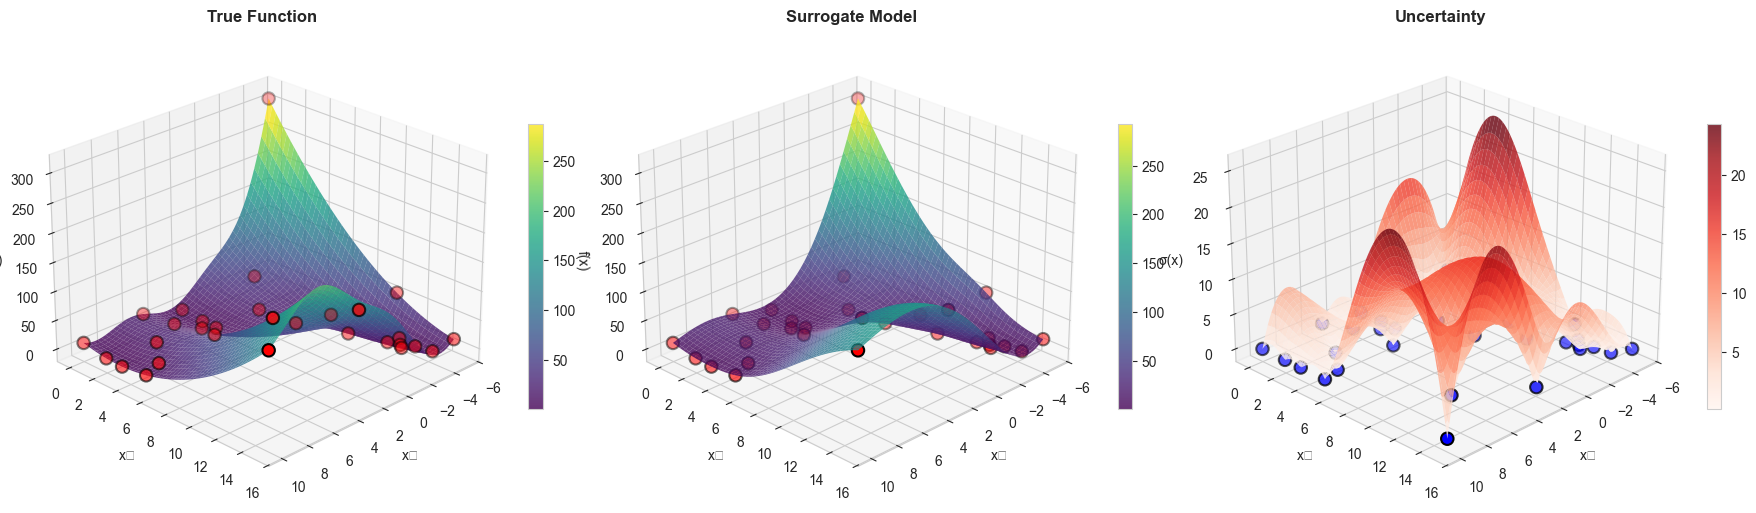


🎨 3D surfaces show the full topology


In [5]:
fig = plt.figure(figsize=(18, 6))

# True function
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(X1_mesh, X2_mesh, Z_true, cmap='viridis', alpha=0.8, 
                         edgecolor='none', antialiased=True)
ax1.scatter(opt.X_[:, 0], opt.X_[:, 1], opt.y_, c='red', s=80, 
            edgecolors='black', linewidth=1.5, depthshade=True)
ax1.set_xlabel('x₁', fontsize=10)
ax1.set_ylabel('x₂', fontsize=10)
ax1.set_zlabel('f(x)', fontsize=10)
ax1.set_title('True Function', fontweight='bold', fontsize=12)
ax1.view_init(elev=25, azim=45)
fig.colorbar(surf1, ax=ax1, shrink=0.5)

# Surrogate
ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(X1_mesh, X2_mesh, Z_pred, cmap='viridis', alpha=0.8, 
                         edgecolor='none', antialiased=True)
ax2.scatter(opt.X_[:, 0], opt.X_[:, 1], opt.y_, c='red', s=80, 
            edgecolors='black', linewidth=1.5, depthshade=True)
ax2.set_xlabel('x₁', fontsize=10)
ax2.set_ylabel('x₂', fontsize=10)
ax2.set_zlabel('f̂(x)', fontsize=10)
ax2.set_title('Surrogate Model', fontweight='bold', fontsize=12)
ax2.view_init(elev=25, azim=45)
fig.colorbar(surf2, ax=ax2, shrink=0.5)

# Uncertainty
ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(X1_mesh, X2_mesh, Z_std, cmap='Reds', alpha=0.8, 
                         edgecolor='none', antialiased=True)
ax3.scatter(opt.X_[:, 0], opt.X_[:, 1], np.zeros_like(opt.y_), c='blue', s=80, 
            edgecolors='black', linewidth=1.5, depthshade=True)
ax3.set_xlabel('x₁', fontsize=10)
ax3.set_ylabel('x₂', fontsize=10)
ax3.set_zlabel('σ(x)', fontsize=10)
ax3.set_title('Uncertainty', fontweight='bold', fontsize=12)
ax3.view_init(elev=25, azim=45)
fig.colorbar(surf3, ax=ax3, shrink=0.5)

plt.tight_layout()
plt.show()

print("\n🎨 3D surfaces show the full topology")

## 5. Acquisition Function Visualization

See where the optimizer will search next.

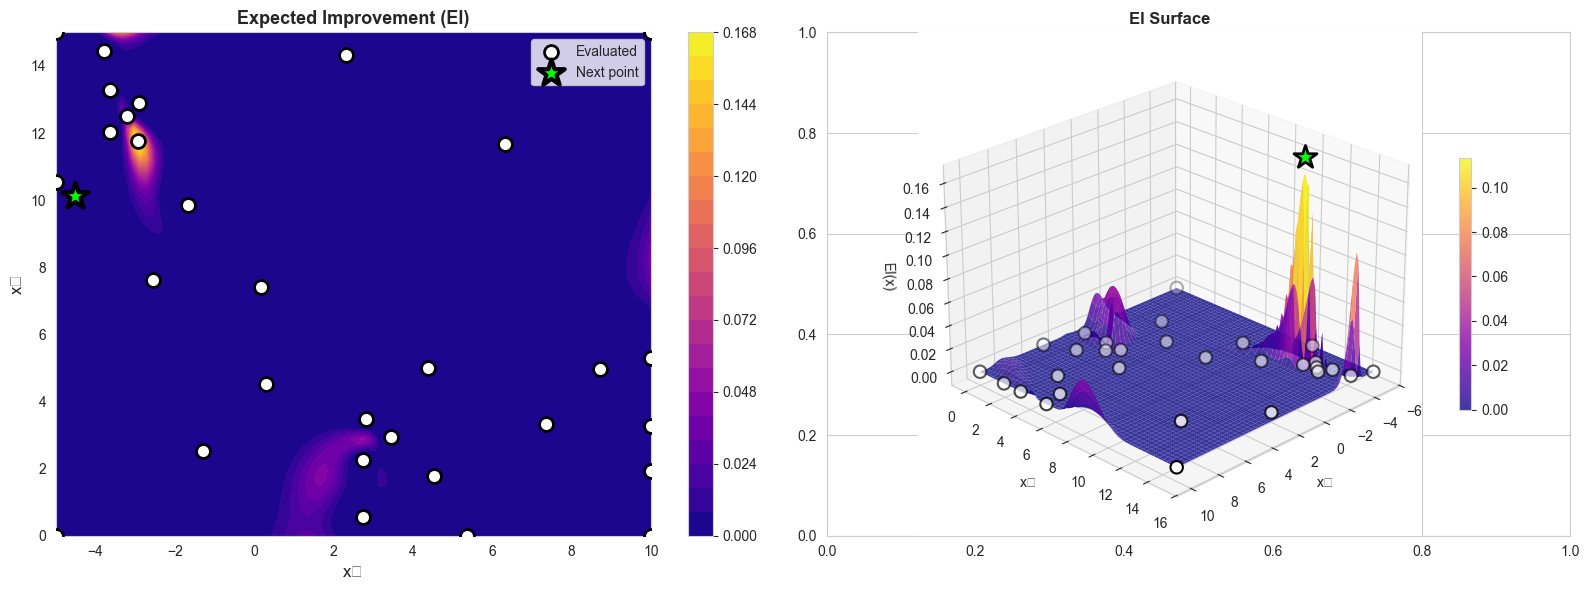


⭐ Next suggested point: [-4.51264599 10.11261963]
   EI value: 0.163171

💡 High EI regions balance low prediction and high uncertainty


In [6]:
# Compute Expected Improvement on grid
f_best = np.min(opt.y_)
Z_acq = (f_best - y_pred_grid) / (y_std_grid + 1e-9)
ei_grid = (f_best - y_pred_grid) * norm.cdf(Z_acq) + y_std_grid * norm.pdf(Z_acq)
ei_grid[y_std_grid < 1e-9] = 0
EI_mesh = ei_grid.reshape(X1_mesh.shape)

# Find next suggested point
next_point = opt._suggest_next_point()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 2D contour
contour = axes[0].contourf(X1_mesh, X2_mesh, EI_mesh, levels=20, cmap='plasma')
axes[0].scatter(opt.X_[:, 0], opt.X_[:, 1], c='white', s=100, edgecolors='black', 
                linewidth=2, label='Evaluated', zorder=5)
axes[0].scatter(next_point[0], next_point[1], c='lime', s=400, marker='*', 
                edgecolors='black', linewidth=3, label='Next point', zorder=6)
axes[0].set_xlabel('x₁', fontsize=12)
axes[0].set_ylabel('x₂', fontsize=12)
axes[0].set_title('Expected Improvement (EI)', fontweight='bold', fontsize=13)
axes[0].legend(fontsize=10)
plt.colorbar(contour, ax=axes[0])

# 3D surface
ax3d = fig.add_subplot(122, projection='3d')
surf = ax3d.plot_surface(X1_mesh, X2_mesh, EI_mesh, cmap='plasma', alpha=0.8, 
                         edgecolor='none', antialiased=True)
ax3d.scatter(opt.X_[:, 0], opt.X_[:, 1], np.zeros(len(opt.X_)), 
             c='white', s=80, edgecolors='black', linewidth=1.5)
ax3d.scatter([next_point[0]], [next_point[1]], [ei_grid[np.argmax(ei_grid)]], 
             c='lime', s=300, marker='*', edgecolors='black', linewidth=2)
ax3d.set_xlabel('x₁', fontsize=10)
ax3d.set_ylabel('x₂', fontsize=10)
ax3d.set_zlabel('EI(x)', fontsize=10)
ax3d.set_title('EI Surface', fontweight='bold', fontsize=12)
ax3d.view_init(elev=25, azim=45)
fig.colorbar(surf, ax=ax3d, shrink=0.5)

plt.tight_layout()
plt.show()

print(f"\n⭐ Next suggested point: {next_point}")
print(f"   EI value: {ei_grid.max():.6f}")
print(f"\n💡 High EI regions balance low prediction and high uncertainty")

## 6. High-Dimensional Visualization

For problems with >2 dimensions, use slice plots and parallel coordinates.

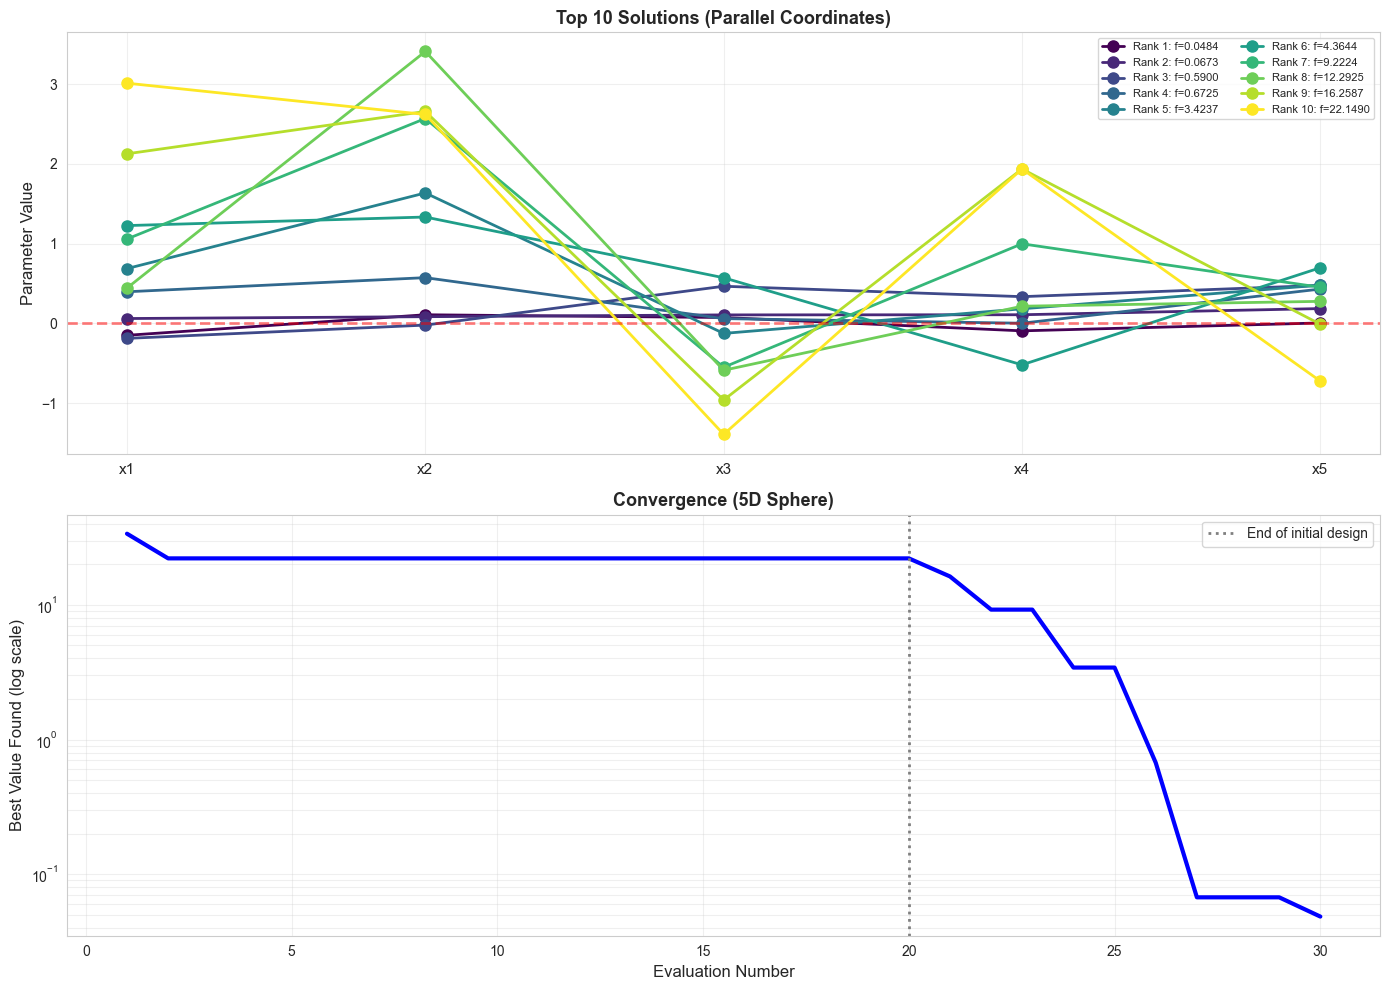


📊 5D Optimization Results:
  Best point: [-0.15058743  0.10726561  0.07267184 -0.09458074  0.00443699]
  Best value: 0.04842889
  Global optimum: 0.0

💡 Parallel coordinates show parameter relationships


In [7]:
# 5D sphere function
opt_5d = SpotOptim(
    fun=lambda X: np.sum(X**2, axis=1),
    bounds=[(-5, 5)] * 5,
    n_initial=20,
    max_iter=30,
    seed=42
)

result_5d = opt_5d.optimize()

# Parallel coordinates plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Top 10 best points
best_indices = np.argsort(opt_5d.y_)[:10]
colors = plt.cm.viridis(np.linspace(0, 1, 10))

for i, idx in enumerate(best_indices):
    ax1.plot(range(5), opt_5d.X_[idx], 'o-', linewidth=2, markersize=8, 
             color=colors[i], label=f'Rank {i+1}: f={opt_5d.y_[idx]:.4f}')

ax1.set_xticks(range(5))
ax1.set_xticklabels([f'x{i+1}' for i in range(5)], fontsize=11)
ax1.set_ylabel('Parameter Value', fontsize=12)
ax1.set_title('Top 10 Solutions (Parallel Coordinates)', fontweight='bold', fontsize=13)
ax1.legend(fontsize=8, ncol=2)
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.5)

# Convergence
evals_5d = np.arange(1, len(opt_5d.y_) + 1)
best_5d = np.minimum.accumulate(opt_5d.y_)

ax2.semilogy(evals_5d, best_5d, 'b-', linewidth=3)
ax2.axvline(opt_5d.n_initial, color='gray', linestyle=':', linewidth=2, 
            label='End of initial design')
ax2.set_xlabel('Evaluation Number', fontsize=12)
ax2.set_ylabel('Best Value Found (log scale)', fontsize=12)
ax2.set_title('Convergence (5D Sphere)', fontweight='bold', fontsize=13)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print(f"\n📊 5D Optimization Results:")
print(f"  Best point: {result_5d.x}")
print(f"  Best value: {result_5d.fun:.8f}")
print(f"  Global optimum: 0.0")
print(f"\n💡 Parallel coordinates show parameter relationships")

## 7. Slice Plots for High Dimensions

Fix all but two dimensions at their best values.

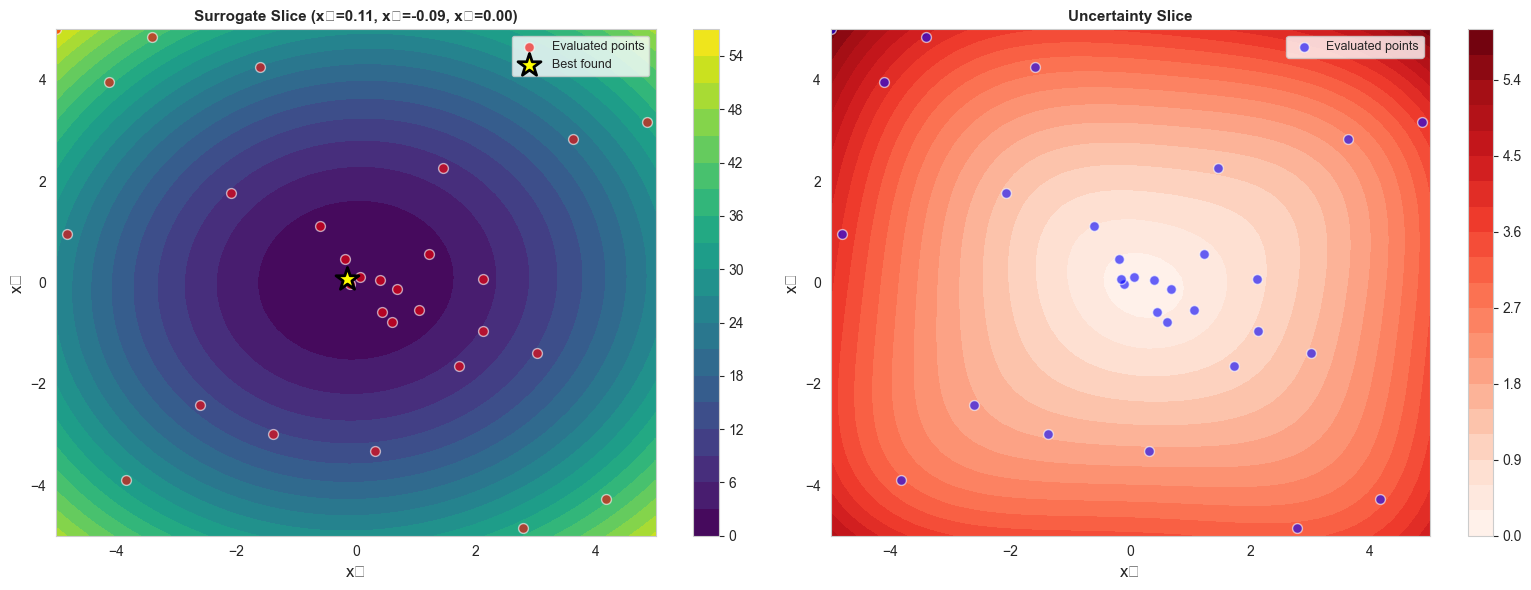


💡 Slice plots reveal 2D structure while fixing other dimensions


In [8]:
# Create slice plot for dimensions 0 and 2
x_best_5d = result_5d.x

# Grid for slice (varying x0 and x2, fixing others)
x0_slice = np.linspace(-5, 5, 50)
x2_slice = np.linspace(-5, 5, 50)
X0_mesh_slice, X2_mesh_slice = np.meshgrid(x0_slice, x2_slice)

# Build full input with fixed values
X_slice = np.zeros((len(x0_slice) * len(x2_slice), 5))
X_slice[:, 0] = X0_mesh_slice.ravel()
X_slice[:, 2] = X2_mesh_slice.ravel()
X_slice[:, 1] = x_best_5d[1]  # Fix x1
X_slice[:, 3] = x_best_5d[3]  # Fix x3
X_slice[:, 4] = x_best_5d[4]  # Fix x4

# Predict
y_slice_pred, y_slice_std = opt_5d._predict_with_uncertainty(X_slice)
Z_slice_pred = y_slice_pred.reshape(X0_mesh_slice.shape)
Z_slice_std = y_slice_std.reshape(X0_mesh_slice.shape)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Prediction slice
contour1 = axes[0].contourf(X0_mesh_slice, X2_mesh_slice, Z_slice_pred, levels=20, cmap='viridis')
axes[0].scatter(opt_5d.X_[:, 0], opt_5d.X_[:, 2], c='red', s=50, edgecolors='white', 
                linewidth=1, alpha=0.6, label='Evaluated points')
axes[0].scatter(x_best_5d[0], x_best_5d[2], c='yellow', s=300, marker='*', 
                edgecolors='black', linewidth=2, label='Best found')
axes[0].set_xlabel('x₁', fontsize=12)
axes[0].set_ylabel('x₃', fontsize=12)
axes[0].set_title(f'Surrogate Slice (x₂={x_best_5d[1]:.2f}, x₄={x_best_5d[3]:.2f}, x₅={x_best_5d[4]:.2f})', 
                  fontweight='bold', fontsize=11)
axes[0].legend(fontsize=9)
plt.colorbar(contour1, ax=axes[0])

# Uncertainty slice
contour2 = axes[1].contourf(X0_mesh_slice, X2_mesh_slice, Z_slice_std, levels=20, cmap='Reds')
axes[1].scatter(opt_5d.X_[:, 0], opt_5d.X_[:, 2], c='blue', s=50, edgecolors='white', 
                linewidth=1, alpha=0.6, label='Evaluated points')
axes[1].set_xlabel('x₁', fontsize=12)
axes[1].set_ylabel('x₃', fontsize=12)
axes[1].set_title('Uncertainty Slice', fontweight='bold', fontsize=11)
axes[1].legend(fontsize=9)
plt.colorbar(contour2, ax=axes[1])

plt.tight_layout()
plt.show()

print("\n💡 Slice plots reveal 2D structure while fixing other dimensions")

## 8. Summary: Visualization Best Practices

### Essential Plots

✅ **Convergence Plots**
- Track best value over iterations
- Use log scale for fine-grained convergence
- Mark initial design phase

✅ **Response Surface (2D Problems)**
- Compare true function vs surrogate
- Visualize uncertainty
- Show sampled points and best found

✅ **Acquisition Function**
- Understand where optimizer searches next
- Verify exploration-exploitation balance

✅ **High-Dimensional Techniques**
- Parallel coordinates for top solutions
- Slice plots (fix all but 2 dimensions)
- Pairwise scatter matrices

### Key Insights from Visualization

1. **Surrogate Quality**: Compare true vs predicted surfaces
2. **Uncertainty**: Low near data, high in unexplored regions
3. **Convergence**: Should show steady improvement
4. **Exploration**: EI should guide toward promising uncertain regions
5. **Exploitation**: Final iterations focus near current best

### SpotOptim Visualization Workflow

```python
# Run optimization
opt.optimize()

# Extract data
X_history = opt.X_          # All evaluated points
y_history = opt.y_          # All function values
best_x = opt.result.x       # Best point
best_y = opt.result.fun     # Best value

# Predict on grid
y_pred, y_std = opt._predict_with_uncertainty(X_grid)

# Visualize!
```

---

**Previous:** [Tutorial 3 - Exploring and Exploiting](03_exploring_exploiting.ipynb)  
**Next:** [Tutorial 5 - Infill Criteria](05_infill_criteria.ipynb)